Text(0.5, 1.0, 'Distribution of post scores in the dataset')

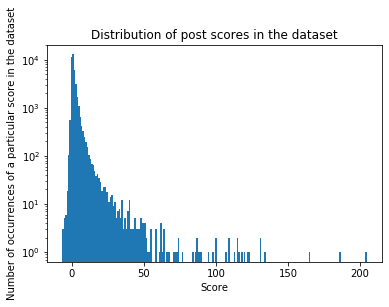

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import sem, t
from scipy import mean
import psycopg2
import os


def establish_db_connection():
    """
    Establish and return a database connection, using values found in the
    DB_[NAME|USER|PASS|HOST|PORT] environment variables, or using the default
    database connection parameters.
    :return: The database connection.
    """
    return psycopg2.connect(
        dbname=os.environ.get("DB_NAME", "sedb"),
        user=os.environ.get("DB_USER", "se_user"),
        password=os.environ.get("DB_PASS", "se_pass"),
        host=os.environ.get("DB_HOST", "localhost"),
        port=os.environ.get("DB_PORT", 5432))



connection = establish_db_connection()
score = pd.read_sql("SELECT score FROM posts",connection) 
a = score.to_numpy()
max_val = 204+0.5
min_val = -6-0.5


binwidth = 1

hist = plt.hist(a, np.arange(min_val,max_val+1), 1)
plt.yscale('log')
plt.xlabel('Score')
plt.ylabel('Number of occurrences of a particular score in the dataset')
plt.title('Distribution of post scores in the dataset')


    

    
    


    

    


(-0.05352852362849056, 0.06732049392009166)

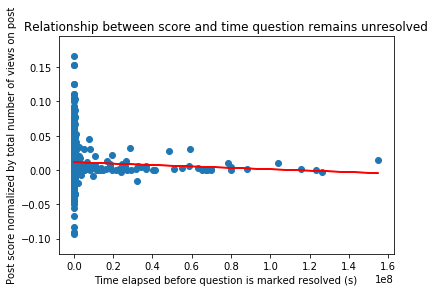

In [330]:
import datetime
from scipy.stats import pearsonr


df = pd.read_sql("SELECT score, view_count,  creation_date, closed_date FROM posts where creation_date IS NOT NULL AND closed_date IS NOT NULL AND view_count IS NOT NULL ",connection)

#df.shape
open_date = df['creation_date'].to_numpy()
closed_date = df['closed_date'].to_numpy()
score = df['score'].to_numpy()
views = df['view_count'].to_numpy()
delta_t = np.subtract(closed_date, open_date)/1e9
time = delta_t.astype('float64')
filtered_time =[time[i] for i, x in enumerate(time) if time[i]>0]
normalized_score = np.divide(score, views)



plt.scatter(filtered_time, normalized_score)
plt.plot(filtered_time, np.poly1d(np.polyfit(filtered_time, normalized_score, 1))(filtered_time),color ='red')
plt.title("Relationship between score and time question remains unresolved")
plt.xlabel("Time elapsed before question is marked resolved (s)")
plt.ylabel("Post score normalized by total number of views on post")

pearsonr(filtered_time, normalized_score)



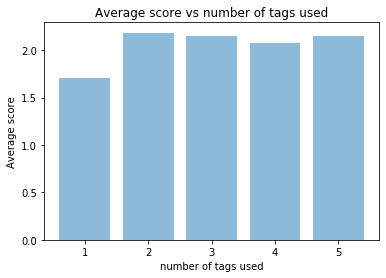

In [320]:
df3 = pd.read_sql("select posts.id, posts.score as score, tags.id as tagID , tags.tag_name As tagName FROM posts INNER JOIN tag_link ON posts.id = tag_link.post_id INNER JOIN tags ON tag_link.tag_id = tags.id ",connection)

count = df3.groupby('id').count()

merged_df = pd.merge(df3, count, how = 'inner', on = 'id')

new_frame = merged_df[['tagid_y','score_x']]

averages = new_frame.groupby('tagid_y').mean()

#print(averages.shape)

y_pos = np.arange(len(averages))
objects = ('1', '2', '3', '4', '5')

plt.bar(y_pos, averages['score_x'], align = 'center', alpha = 0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Average score')
plt.xlabel("number of tags used")
plt.title('Average score vs number of tags used')

plt.show()


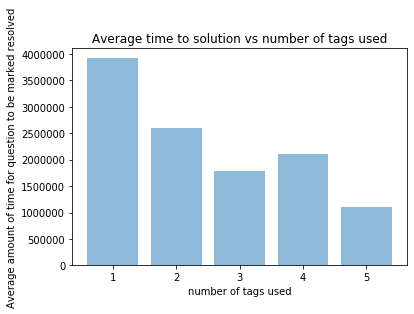

In [319]:
df4 = pd.read_sql("select posts.id, tags.id as tagID , tags.tag_name As tagName, posts.creation_date, posts.closed_date, posts.view_count  FROM posts INNER JOIN tag_link ON posts.id = tag_link.post_id INNER JOIN tags ON tag_link.tag_id = tags.id where creation_date IS NOT NULL AND closed_date IS NOT NULL AND view_count IS NOT NULL",connection)

count2 = df4.groupby('id').count()


merged_df2 = pd.merge(df4, count2, how = 'inner', on = 'id')

delta_t = np.subtract(merged_df2['closed_date_x'].to_numpy(), merged_df2['creation_date_x'].to_numpy())/1e9
time = delta_t.astype('float64')

num_tags = merged_df['tagid_y'].to_numpy()

newest_frame = pd.DataFrame({'time_diff': time,'num_tags': num_tags})

average_time2res = newest_frame.groupby('num_tags').mean()

average_time2res.head()

objects = ('1', '2', '3', '4', '5')

y_pos = np.arange(len(averages))
plt.bar(y_pos, average_time2res['time_diff'], align = 'center', alpha = 0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Average amount of time for question to be marked resolved')
plt.xlabel("number of tags used")
plt.title('Average time to solution vs number of tags used')

plt.show()




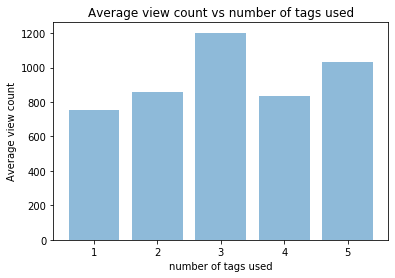

In [327]:

last_frame = merged_df2[['tagid_y','view_count_x']]
average_views = last_frame.groupby('tagid_y').mean()
average_views.head()
y_pos = np.arange(len(averages))
objects = ('1', '2', '3', '4', '5')

plt.bar(y_pos, average_views['view_count_x'], align = 'center', alpha = 0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Average view count')
plt.xlabel("number of tags used")
plt.title('Average view count vs number of tags used')

plt.show()

Text(0.5, 1.0, 'Score distribution for unresolved questions')

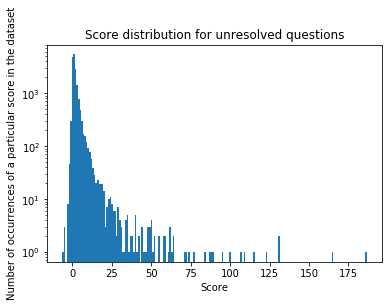

In [134]:
import datetime
import plotly.express as px


df2 = pd.read_sql("SELECT score, view_count FROM posts where creation_date IS NOT NULL AND closed_date IS NULL AND view_count IS NOT NULL ",connection)



score_array = df2['score'].to_numpy()

max_val2 = np.amax(score_array)+0.5
min_val2 = np.amin(score_array)-0.5


plt.hist(score_array, np.arange(min_val2,max_val2+1),1)
plt.yscale('log')
plt.xlabel('Score')
plt.ylabel('Number of occurrences of a particular score in the dataset')
plt.title('Score distribution for unresolved questions')




Text(0.5, 1.0, 'View Count distribution for unresolved questions')

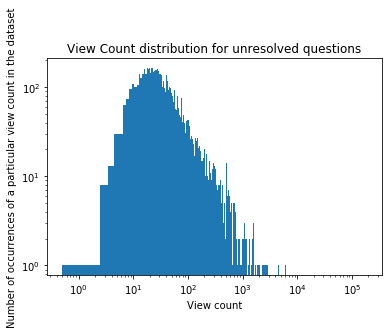

In [137]:
view_array = df2['view_count'].to_numpy()

max_val3 = np.amax(view_array)+0.5
min_val3 = np.amin(view_array)-0.5


plt.hist(view_array, np.arange(min_val3,max_val3+1),1)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('View count')
plt.ylabel('Number of occurrences of a particular view count in the dataset')
plt.title('View Count distribution for unresolved questions')

In [383]:
from nltk.corpus import stopwords
import string
import nltk
nltk.download('stopwords')



negative_text = pd.read_sql("SELECT title, score FROM posts where title IS NOT NULL AND score <0", connection)

positive_text = pd.read_sql("SELECT title, score FROM posts where title IS NOT NULL AND score >=0", connection)

train_set_negative = negative_text.loc[0:0.7*len(negative_text),:]

train_set_positive = positive_text.loc[0:0.7*len(positive_text),:]

test_set_negative = negative_text.loc[0.7*len(negative_text)+1:len(negative_text),:]

test_set_positive = positive_text.loc[0.7*len(positive_text)+1:len(positive_text),:]

training_set = pd.concat([train_set_negative, train_set_positive], axis = 0)

training_set = training_set.reset_index(drop = True)

testing_set = pd.concat([test_set_negative, test_set_positive], axis = 0)

testing_set = testing_set.reset_index(drop = True)

def clean_doc(doc):
    # split into tokens by white space
    tokens=[]
    for i, titles in doc.iterrows():
        token = doc.loc[i,'title']
        token = token.split()
        tokens = token+tokens
    # remove punctuation from each token
    table = str.maketrans('', '', string.punctuation)
    tokens = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 1]
    return tokens

training_set.shape
tokens = clean_doc(training_set)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\delsa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [381]:
# ytrain = training_set['score'].to_numpy()
# ytrain[ytrain>=0] = 1
# ytrain[ytrain < 0] = 0


In [382]:
#ytrain[ytrain>=0] = 1
#print(ytrain)

[0 0 0 ... 1 1 1]


In [384]:
print(tokens)

['InvalidArgumentError', 'placeholder', 'Better', 'code', 'completion', 'python', 'notebooks', 'Images', 'similarity', 'using', 'SIFT', 'Annoy', 'Unexpected', 'shape', 'training', 'curves', 'NN', 'Dealing', 'Error', 'Neural', 'Network', 'input', 'operating', 'dataset', 'records', 'Production', 'TensorFlow', 'Keras', 'Meaning', 'subscript', 'min', 'max', 'value', 'function', 'Divide', 'column', 'mutateat', 'dplyr', 'Multiple', 'season', 'decomposition', 'SeasonalTrend', 'Decomposition', 'STD', 'How', 'use', 'LSTM', 'Networks', 'timeseries', 'classification', 'problems', 'How', 'compare', 'two', 'dataframes', 'put', 'counted', 'unique', 'values', 'first', 'dataframes', 'column', 'Can', 'save', 'prediction', 'value', 'csv', 'file', 'another', 'column', 'using', 'panda', 'python', 'Implementation', 'Siamese', 'network', 'How', 'single', 'image', 'normalization', 'help', 'face', 'recognition', 'model', 'training', 'LSTM', 'Long', 'Term', 'Dependencies', 'Keras', 'How', 'choose', 'best', 'mo

In [385]:
from collections import Counter
vocab = Counter()
vocab.update(tokens)
print(vocab.most_common(50))

[('How', 2111), ('data', 1733), ('What', 868), ('model', 736), ('using', 698), ('learning', 698), ('use', 484), ('classification', 472), ('neural', 454), ('network', 433), ('Is', 417), ('Why', 396), ('regression', 380), ('time', 362), ('features', 361), ('training', 346), ('dataset', 342), ('Data', 338), ('Neural', 315), ('function', 309), ('machine', 302), ('Learning', 297), ('Keras', 294), ('feature', 285), ('set', 277), ('values', 260), ('algorithm', 257), ('Python', 255), ('different', 255), ('text', 251), ('vs', 250), ('series', 250), ('based', 245), ('CNN', 231), ('one', 225), ('LSTM', 224), ('Network', 223), ('input', 222), ('Machine', 222), ('multiple', 213), ('number', 212), ('prediction', 208), ('Can', 207), ('problem', 205), ('python', 203), ('output', 203), ('image', 192), ('accuracy', 190), ('models', 186), ('two', 180)]


Epoch 1/50
 - 3s - loss: 0.1725 - accuracy: 0.9751
Epoch 2/50
 - 3s - loss: 0.1015 - accuracy: 0.9752
Epoch 3/50
 - 3s - loss: 0.0772 - accuracy: 0.9752
Epoch 4/50
 - 3s - loss: 0.0613 - accuracy: 0.9755
Epoch 5/50
 - 3s - loss: 0.0502 - accuracy: 0.9770
Epoch 6/50
 - 3s - loss: 0.0418 - accuracy: 0.9808
Epoch 7/50
 - 4s - loss: 0.0352 - accuracy: 0.9869
Epoch 8/50
 - 3s - loss: 0.0296 - accuracy: 0.9900
Epoch 9/50
 - 3s - loss: 0.0245 - accuracy: 0.9927
Epoch 10/50
 - 3s - loss: 0.0203 - accuracy: 0.9951
Epoch 11/50
 - 3s - loss: 0.0167 - accuracy: 0.9961
Epoch 12/50
 - 4s - loss: 0.0138 - accuracy: 0.9971
Epoch 13/50
 - 4s - loss: 0.0111 - accuracy: 0.9978
Epoch 14/50
 - 3s - loss: 0.0095 - accuracy: 0.9979
Epoch 15/50
 - 3s - loss: 0.0080 - accuracy: 0.9986
Epoch 16/50
 - 4s - loss: 0.0065 - accuracy: 0.9991
Epoch 17/50
 - 3s - loss: 0.0054 - accuracy: 0.9992
Epoch 18/50
 - 4s - loss: 0.0046 - accuracy: 0.9994
Epoch 19/50
 - 4s - loss: 0.0038 - accuracy: 0.9996
Epoch 20/50
 - 4s - l

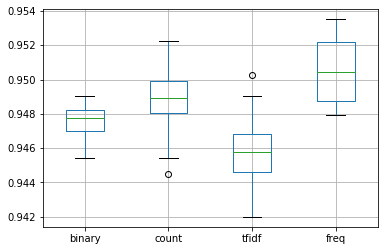

In [386]:
from numpy import array
from string import punctuation
from os import listdir
from collections import Counter
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from pandas import DataFrame
from matplotlib import pyplot


# Xtrain = training_set['title']
ytrain = training_set['score']
ytrain = ytrain.to_numpy()
ytrain[ytrain>=0] = 1
ytrain[ytrain<0] = 0

#Xtest = training_set['title']
ytest = testing_set['score'].to_numpy()
ytest[ytest>=0] = 1
ytest[ytest<0] = 0



def evaluate_mode(Xtrain, ytrain, Xtest, ytest):
    scores = list()
    n_repeats = 10
    n_words = Xtest.shape[1]
    for i in range(n_repeats):
        # define network
        model = Sequential()
        model.add(Dense(50, input_shape=(n_words,), activation='relu'))
        model.add(Dense(1, activation='sigmoid'))
        # compile network
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        # fit network
        model.fit(Xtrain, ytrain, epochs=50, verbose=2)
        # evaluate
        loss, acc = model.evaluate(Xtest, ytest, verbose=0)
        scores.append(acc)
        print('%d accuracy: %s' % ((i+1), acc))
    return scores

def prepare_data(train_docs, test_docs, mode):
    # create the tokenizer
    tokenizer = Tokenizer()
    # fit the tokenizer on the documents
    tokenizer.fit_on_texts(train_docs)
    # encode training data set
    Xtrain = tokenizer.texts_to_matrix(train_docs, mode=mode)
    # encode training data set
    Xtest = tokenizer.texts_to_matrix(test_docs, mode=mode)
    return Xtrain, Xtest
  
modes = ['binary', 'count', 'tfidf', 'freq']
results = DataFrame()
for mode in modes:
    Xtrain, Xtest = prepare_data(training_set['title'], testing_set['title'], mode)
    # prepare data for mode
    results[mode] = evaluate_mode(Xtrain, ytrain, Xtest, ytest)
# summarize results
print(results.describe())
# plot results
results.boxplot()
pyplot.show()

                                                  title  score
0     Is it safe to say if features are generated on...     -1
1     Alert generation on unseen data using deep lea...     -1
2     How many datasets are required in a prediction...     -1
3     Counting the occurrence of each string in a pa...     -1
4     Need Advice, Classification Problem in Python:...     -1
...                                                 ...    ...
5546  Create labels or annotation from two color images      0
5547  Can I update weights of keras neural net only ...      0
5548  How to create dictionaries out of pandas dataf...      0
5549   Real Analysis like convergence of loss functions      0
5550  Shrink the training set during the learning pr...      0

[5551 rows x 2 columns]


[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
